In [1]:
import torch
import numpy as np
import pandas as pd
from functools import partial

In [2]:
import folktexts
print(f"{folktexts.__version__=}")

folktexts.__version__='0.0.3'


In [3]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

Global constants:

In [4]:
MODELS_DIR = "/Users/acruz/data/huggingface-models/"
# MODELS_DIR = "/fast/acruz/huggingface-models"

# MODEL_NAME = "gpt2"
# MODEL_NAME = "google/gemma-1.1-2b-it"
MODEL_NAME = "google/gemma-2b"

SEED = 42
rng = np.random.default_rng(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "mps"

In [5]:
from folktexts.llm_utils import get_model_folder_path
model_path = get_model_folder_path(MODEL_NAME, root_dir=MODELS_DIR)
model_path

'/Users/acruz/data/huggingface-models/google--gemma-2b'

In [6]:
from folktexts.llm_utils import load_model_tokenizer

model, tokenizer = load_model_tokenizer(model_path)
model.to(DEVICE);

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Moving model to device: mps


In [7]:
from folktexts.acs import ACSDataset

acs_income_data = ACSDataset(task_name="ACSIncome", val_size=0, subsampling=0.001)
acs_income_data

In [8]:
X_test, y_test = acs_income_data.get_test()
print(f"{X_test.shape=}")

X_test.shape=(166, 10)


In [9]:
X_train, y_train = acs_income_data.get_train()
print(f"{X_train.shape=}")

X_train.shape=(1498, 10)


---

Example row:

In [10]:
n=5
example_indices = rng.permutation(len(X_train))[:n]

X_train = X_train.iloc[example_indices]
y_train = y_train.iloc[example_indices]
y_train

248380     1
2431385    0
317712     1
1624450    0
951279     0
Name: PINCP_binary, dtype: int64

In [11]:
from folktexts.prompting import encode_row_prompt, encode_row_prompt_few_shot, encode_row_prompt_chat
# encode_row_func = encode_row_prompt                                            # Regular encoding
# encode_row_func = partial(encode_row_prompt_chat, tokenizer=tokenizer)         # Chat-style encoding
encode_row_func = partial(encode_row_prompt_few_shot, n_shots=3, reuse_examples=True)     # Few-shot encoding

In [12]:
row_prompts = [
    encode_row_func(row, dataset=acs_income_data)
    for _, row in X_train.iterrows()
]
print(row_prompts[0], end="**")

The following data corresponds to different survey respondents. Please answer each question based on the information provided. The data provided is enough to reach an approximate answer for each person.

Information:
- The age is 53 years old.
- The current employment status is owner of non-incorporated business, professional practice, or farm.
- The highest grade completed is Bachelor's degree.
- The marital status is married.
- The occupation is musicians and singers.
- The place of birth is New York/NY.
- The relationship to the reference person in the household is the 'reference person' itself.
- The usual number of hours worked per week is 20 hours.
- The sex is Male.
- The race is White.

Question: What is this person's estimated yearly income?
A. Below $50,000.
B. Above $50,000.
Answer: A

Information:
- The age is 51 years old.
- The current employment status is working for a for-profit private company or organization.
- The highest grade completed is 11th grade.
- The marital 

In [13]:
prompts_tok_len = [len(tokenizer.encode(p)) for p in row_prompts]
print("Prompts' token length:", prompts_tok_len)

Prompts' token length: [720, 719, 715, 710, 710]


In [14]:
def max_n_tokens(probs_sequences: list[list[float]], tokenizer, n=5) -> list[list[str]]:
    return [
        [
            tokenizer.decode(tok_id)
            for tok_id in np.argsort(p_seq)[-n:]
        ]
        for p_seq in probs_sequences
    ]

Querying the model:

In [15]:
%%time
from folktexts.querying import query_model_batch
probs_row_prompts = query_model_batch(row_prompts, model, tokenizer, context_size=max(prompts_tok_len)+1)

CPU times: user 301 ms, sys: 293 ms, total: 594 ms
Wall time: 6.19 s


In [16]:
from folktexts.decoding import get_answer_to_question, get_risk_estimate_from_answers

for i in range(len(y_train)):
    # Answers using simple row template
    row_answers = get_answer_to_question(acs_income_data.question, probs_row_prompts[i], tokenizer)
    row_risk_estimate = get_risk_estimate_from_answers(row_answers)
    
    print(f"{i} :: label={y_train.iloc[i]}")
    print(f"\t risk-score:  {row_risk_estimate}")
    print(f"\t all-answers:  {row_answers}")
    print("\n\n")

DEBUG:root:prefix='' has density 0.00%
DEBUG:root:prefix=' ' has density 98.88%
DEBUG:root:Answers have 98.88% probability assigned.
DEBUG:root:prefix='' has density 0.00%
DEBUG:root:prefix=' ' has density 98.68%
DEBUG:root:Answers have 98.68% probability assigned.
DEBUG:root:prefix='' has density 0.00%
DEBUG:root:prefix=' ' has density 99.15%
DEBUG:root:Answers have 99.15% probability assigned.
DEBUG:root:prefix='' has density 0.00%
DEBUG:root:prefix=' ' has density 99.07%
DEBUG:root:Answers have 99.07% probability assigned.
DEBUG:root:prefix='' has density 0.00%
DEBUG:root:prefix=' ' has density 99.07%
DEBUG:root:Answers have 99.07% probability assigned.


0 :: label=1
	 row-prompts:  0.5150617283950617
	 row-prompts:  {Choice(text='Below $50,000', value=0, numeric_value=None): 0.4849382716049383, Choice(text='Above $50,000', value=1, numeric_value=None): 0.5150617283950617}



1 :: label=0
	 row-prompts:  0.48936170212765956
	 row-prompts:  {Choice(text='Below $50,000', value=0, numeric_value=None): 0.5106382978723404, Choice(text='Above $50,000', value=1, numeric_value=None): 0.48936170212765956}



2 :: label=1
	 row-prompts:  0.5057867520315193
	 row-prompts:  {Choice(text='Below $50,000', value=0, numeric_value=None): 0.49421324796848065, Choice(text='Above $50,000', value=1, numeric_value=None): 0.5057867520315193}



3 :: label=0
	 row-prompts:  0.5367175948743224
	 row-prompts:  {Choice(text='Below $50,000', value=0, numeric_value=None): 0.4632824051256777, Choice(text='Above $50,000', value=1, numeric_value=None): 0.5367175948743224}



4 :: label=0
	 row-prompts:  0.531296205027107
	 row-prompts:  {Choice(text='Below $50,000', 

In [17]:
print("Highest likelihood tokens for row prompts")
max_n_tokens(probs_row_prompts, tokenizer, n=5)

Highest likelihood tokens for row prompts


[[' None', ' D', ' C', ' A', ' B'],
 [' None', ' D', ' C', ' B', ' A'],
 [' None', ' D', ' C', ' A', ' B'],
 [' None', ' D', ' C', ' A', ' B'],
 [' None', ' D', ' C', ' A', ' B']]

---

In [19]:
%%time
from folktexts.querying import compute_task_risk_estimates
results = compute_task_risk_estimates(
    model=model,
    tokenizer=tokenizer,
    dataset=acs_income_data,
)

Computing risk estimates:   0%|          | 0/188 [00:00<?, ?it/s]

DEBUG:root:prefix='' has density 0.22%
DEBUG:root:prefix=' ' has density 39.18%
DEBUG:root:Answers have 39.18% probability assigned.
DEBUG:root:prefix='' has density 0.24%
DEBUG:root:prefix=' ' has density 39.31%
DEBUG:root:Answers have 39.31% probability assigned.
DEBUG:root:prefix='' has density 0.23%
DEBUG:root:prefix=' ' has density 35.91%
DEBUG:root:Answers have 35.91% probability assigned.
DEBUG:root:prefix='' has density 0.25%
DEBUG:root:prefix=' ' has density 36.57%
DEBUG:root:Answers have 36.57% probability assigned.
DEBUG:root:prefix='' has density 0.26%
DEBUG:root:prefix=' ' has density 36.62%
DEBUG:root:Answers have 36.62% probability assigned.
DEBUG:root:prefix='' has density 0.25%
DEBUG:root:prefix=' ' has density 34.85%
DEBUG:root:Answers have 34.85% probability assigned.
DEBUG:root:prefix='' has density 0.24%
DEBUG:root:prefix=' ' has density 38.26%
DEBUG:root:Answers have 38.26% probability assigned.
DEBUG:root:prefix='' has density 0.23%
DEBUG:root:prefix=' ' has dens

Computing risk estimates:   0%|          | 0/21 [00:00<?, ?it/s]

DEBUG:root:prefix='' has density 0.21%
DEBUG:root:prefix=' ' has density 36.54%
DEBUG:root:Answers have 36.54% probability assigned.
DEBUG:root:prefix='' has density 0.23%
DEBUG:root:prefix=' ' has density 37.79%
DEBUG:root:Answers have 37.79% probability assigned.
DEBUG:root:prefix='' has density 0.27%
DEBUG:root:prefix=' ' has density 35.51%
DEBUG:root:Answers have 35.51% probability assigned.
DEBUG:root:prefix='' has density 0.24%
DEBUG:root:prefix=' ' has density 37.67%
DEBUG:root:Answers have 37.67% probability assigned.
DEBUG:root:prefix='' has density 0.25%
DEBUG:root:prefix=' ' has density 37.81%
DEBUG:root:Answers have 37.81% probability assigned.
DEBUG:root:prefix='' has density 0.29%
DEBUG:root:prefix=' ' has density 37.92%
DEBUG:root:Answers have 37.92% probability assigned.
DEBUG:root:prefix='' has density 0.27%
DEBUG:root:prefix=' ' has density 38.38%
DEBUG:root:Answers have 38.38% probability assigned.
DEBUG:root:prefix='' has density 0.26%
DEBUG:root:prefix=' ' has dens

CPU times: user 27.8 s, sys: 18.4 s, total: 46.3 s
Wall time: 6min 38s


In [20]:
from sklearn.metrics import RocCurveDisplay, accuracy_score, balanced_accuracy_score

_X, y_train = acs_income_data.get_train()
y_train_pred = results["train"]
print(f"accuracy: {accuracy_score(y_true=y_train, y_pred=y_train_pred >= 0.5)}")
print(f"Bal. accuracy: {balanced_accuracy_score(y_true=y_train, y_pred=y_train_pred >= 0.5)}")

accuracy: 0.5961281708945261
Bal. accuracy: 0.63237760356548


In [21]:
logging.getLogger().setLevel(logging.INFO)

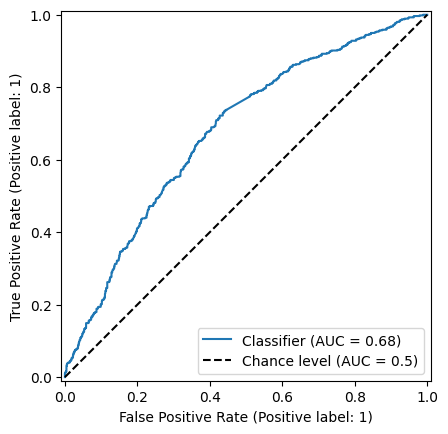

In [22]:
RocCurveDisplay.from_predictions(y_true=y_train, y_pred=y_train_pred, plot_chance_level=True)

<Axes: ylabel='Count'>

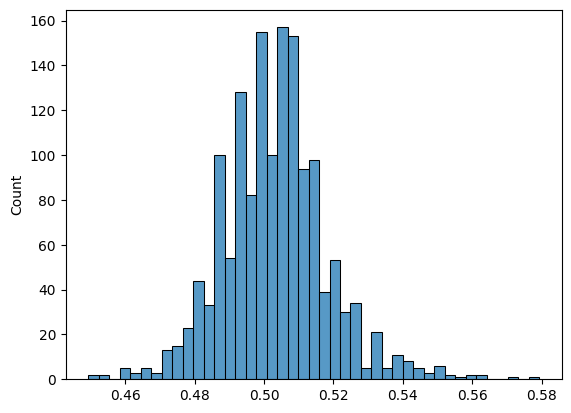

In [23]:
import seaborn as sns
sns.histplot(y_train_pred)

In [24]:
df = pd.DataFrame({"score": y_train_pred, "label": y_train}).reset_index(drop=True)
df.head()

,score,label
0,0.500000,0
1,0.507764,0
2,0.500000,1
3,0.502003,1
4,0.513667,1


(0.4493771957840945, 0.5792838874680307)

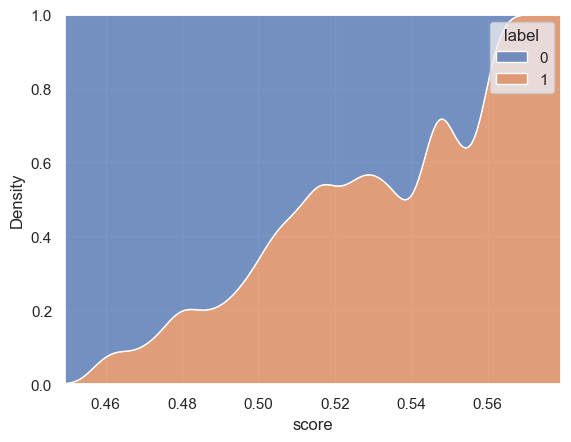

In [28]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
sns.kdeplot(df, x="score", hue="label", multiple="fill")
plt.xlim(y_train_pred.min(), y_train_pred.max())

In [29]:
import importlib
import folktexts.evaluation
importlib.reload(folktexts.evaluation)

<module 'folktexts.evaluation' from '/Users/acruz/Documents/folktexts/folktexts/evaluation.py'>

In [30]:
import folktexts.evaluation
from pathlib import Path

results = folktexts.evaluation.evaluate_predictions(
    y_true=y_train.to_numpy(),
    y_pred_scores=y_train_pred,
    imgs_dir=Path("../imgs"),
)
results

{'accuracy': 0.6281708945260347,
 'tpr': 0.7217235188509874,
 'fnr': 0.27827648114901254,
 'fpr': 0.42720510095642933,
 'tnr': 0.5727948990435706,
 'balanced_accuracy': 0.6472592089472791,
 'precision': 0.5,
 'ppr': 0.5367156208277704,
 'log_loss': 0.6867538486943024,
 'brier_score_loss': 0.24680695618747117,
 'roc_auc': 0.6775356443067365,
 'ece': 0.13124855194258334,
 'ece_scaled': 0.055769772872202146,
 'ece_quantile': 0.14941633101004267,
 'roc_curve_path': '/Users/acruz/Documents/folktexts/imgs/roc_curve.png',
 'calibration_curve_path': '/Users/acruz/Documents/folktexts/imgs/calibration_curve.png',
 'score_distribution_path': '/Users/acruz/Documents/folktexts/imgs/score_distribution.png',
 'score_distribution_per_label_path': '/Users/acruz/Documents/folktexts/imgs/score_distribution_per_label.png'}